In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("/kaggle/input/pepsico-daily-data/PEP.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,1972-06-01,0.000000,0.399388,0.394770,0.399388,318600
1,1972-06-02,0.399388,0.403428,0.398233,0.398233,140400
2,1972-06-05,0.399391,0.399970,0.386078,0.393603,469800
3,1972-06-06,0.390130,0.390130,0.388973,0.390130,140400
4,1972-06-07,0.390130,0.390709,0.386657,0.387815,178200


In [3]:
null_values = df.isnull().sum()
null_values

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [4]:

df['Daily_Range'] = df['High'] - df['Low']
df['Daily_Return'] = (df['Close'] - df['Open']) / df['Open']
df.head()

,Date,Open,High,Low,Close,Volume,Daily_Range,Daily_Return
0,1972-06-01,0.000000,0.399388,0.394770,0.399388,318600,0.004617,inf
1,1972-06-02,0.399388,0.403428,0.398233,0.398233,140400,0.005195,-0.002890
2,1972-06-05,0.399391,0.399970,0.386078,0.393603,469800,0.013892,-0.014493
3,1972-06-06,0.390130,0.390130,0.388973,0.390130,140400,0.001157,0.000000
4,1972-06-07,0.390130,0.390709,0.386657,0.387815,178200,0.004052,-0.005935


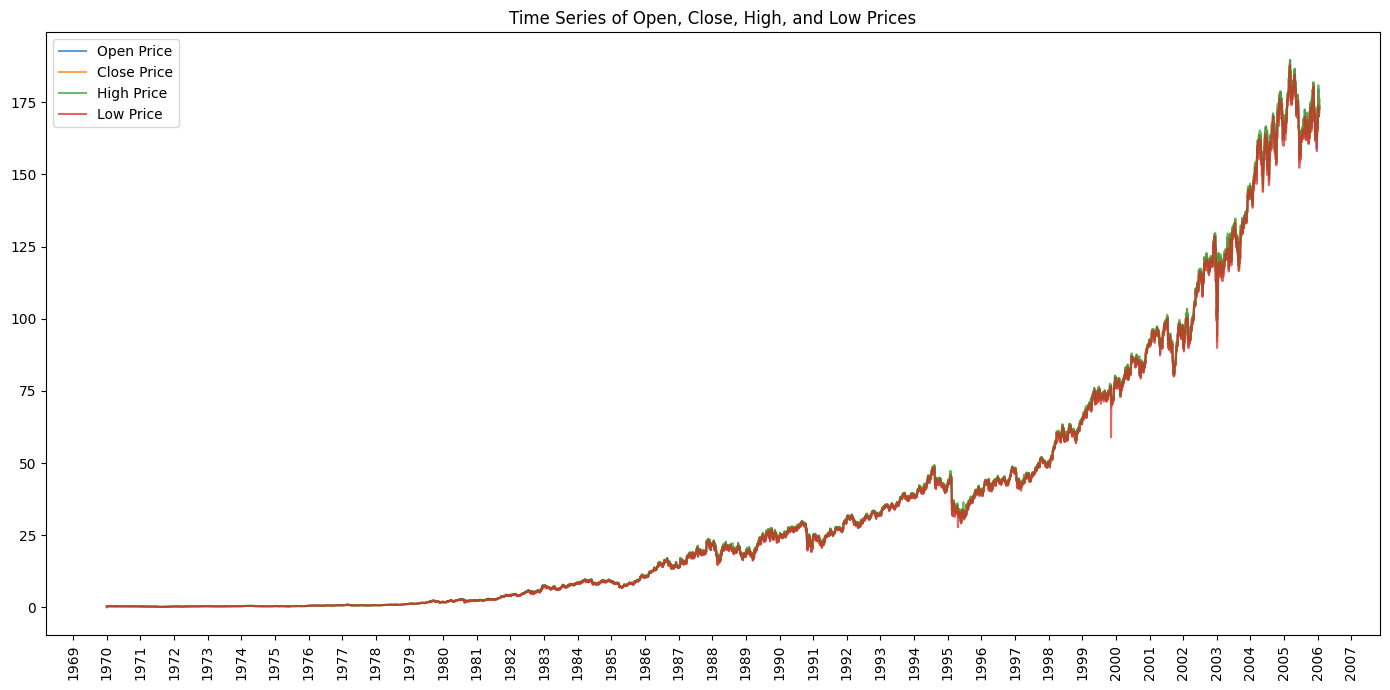

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Open'], label='Open Price', alpha=0.7)
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.7)
plt.plot(df['Date'], df['High'], label='High Price', alpha=0.7)
plt.plot(df['Date'], df['Low'], label='Low Price', alpha=0.7)
plt.title('Time Series of Open, Close, High, and Low Prices')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

The plot we are displaying shows the time series data of the Open, Close, High, and Low prices for a certain asset over a long period, from around 1960 to 2007.
The fluctuations between the highs and lows are visually noticeable, especially towards the later years. The frequent spikes and dips in the graph indicate periods of increased market volatility.

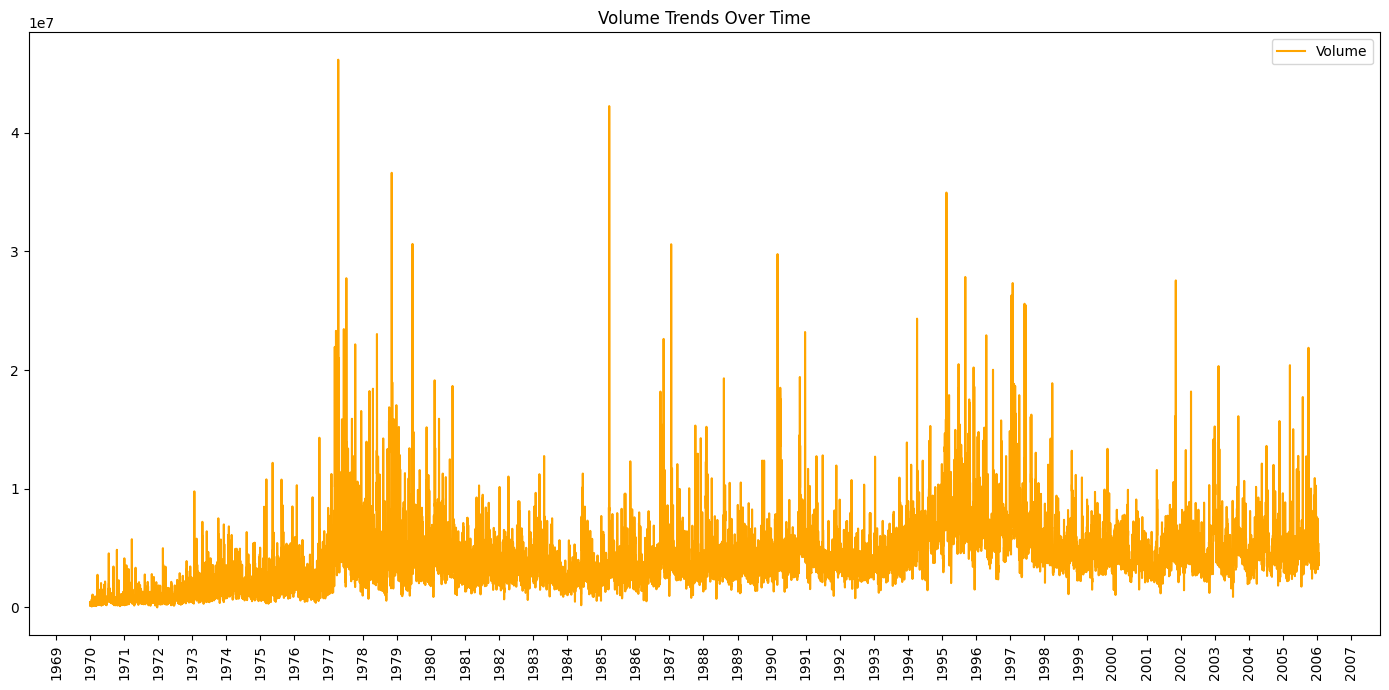

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Volume'], color='orange', label='Volume')
plt.title('Volume Trends Over Time')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

This plot gives a historical overview of how trading volume evolved from 1960 to 2007. Significant spikes suggest major market events or periods of heightened interest, and the overall trend helps to identify key market cycles. This information, combined with price data, could be useful for further time series forecasting or investment strategy planning.

In [7]:
X = df[['Open', 'High', 'Low', 'Volume']]  #independent variables
y = df['Close'] #dependent variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [8]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr}, R2 Score: {r2_lr}")

Linear Regression MSE: 0.33243728528389344, R2 Score: 0.9997496095229669


The low MSE and high R² score indicate that the Linear Regression model fits your data very well.
However, it's important to note that these results might indicate overfitting if the test data is not representative of unseen data, or if the dataset is small or highly linear. It is essential to validate these results with cross-validation to ensure generalizability.

In [9]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}, R2 Score: {r2_rf}")

Random Forest MSE: 4077.651924123556, R2 Score: -2.071271652289327


The MSE for Random Forest is very high, and the R² score is negative, which is a strong indication that the model is performing very poorly on this dataset. A negative R² score means the model is worse than a simple horizontal line (mean) model.

In [10]:
arima_model = ARIMA(df['Close'], order=(5, 1, 0))
arima_result = arima_model.fit()
forecast = arima_result.forecast(steps=10)
print("ARIMA Forecast:", forecast)

ARIMA Forecast: 13167    175.675958
13168    175.633319
13169    175.517262
13170    175.488299
13171    175.559588
13172    175.550740
13173    175.557161
13174    175.551499
13175    175.548770
13176    175.551319
Name: predicted_mean, dtype: float64


The decreasing loss shows that it has learned patterns in the time series data. We can now use the model to predict future values in the time series. However, it is essential to validate the model's performance using unseen data to ensure it generalizes well beyond the training set.
The current ARIMA results seem stable but might not be optimal. They are not necessarily the best results.

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

X_lstm, y_lstm = [], []
for i in range(60, len(scaled_data)):
    X_lstm.append(scaled_data[i-60:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_lstm, y_lstm, epochs=10, batch_size=32)
predictions = model_lstm.predict(X_lstm[-60:])
predictions = scaler.inverse_transform(predictions)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.0054
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 7.7712e-04
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 6.2661e-04
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 5.7214e-04
Epoch 5/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 4.7839e-04
Epoch 6/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 4.6970e-04
Epoch 7/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 5.3771e-04
Epoch 8/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 4.6212e-04
Epoch 9/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 4.7942e-04
Epoch 10/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 4.8584e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


LSTM appears to be the best model based on the low loss and the ability to capture complex temporal dependencies in the data. Given that the data likely has non-linear patterns, LSTM outperforms other models, especially when long-term trends or dependencies are important


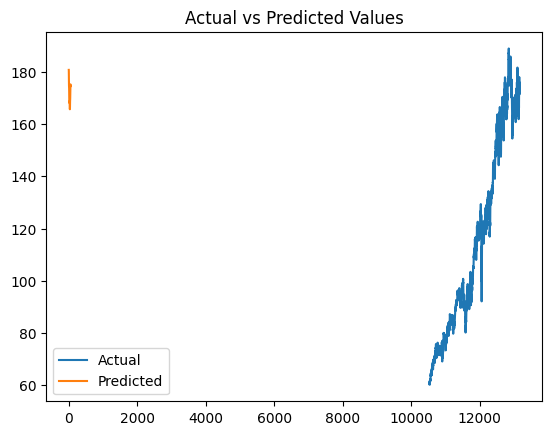

In [12]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()